# IIC-3641 GML UC

- Versiones de librerías, python 3.10.2
- AmpliGraph: https://github.com/Accenture/AmpliGraph/tree/develop

In [1]:
import ampligraph

ampligraph.__version__

2024-09-08 18:11:56.869786: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


'2.1.0'

## Vamos a trabajar con un grafo heterogéneo

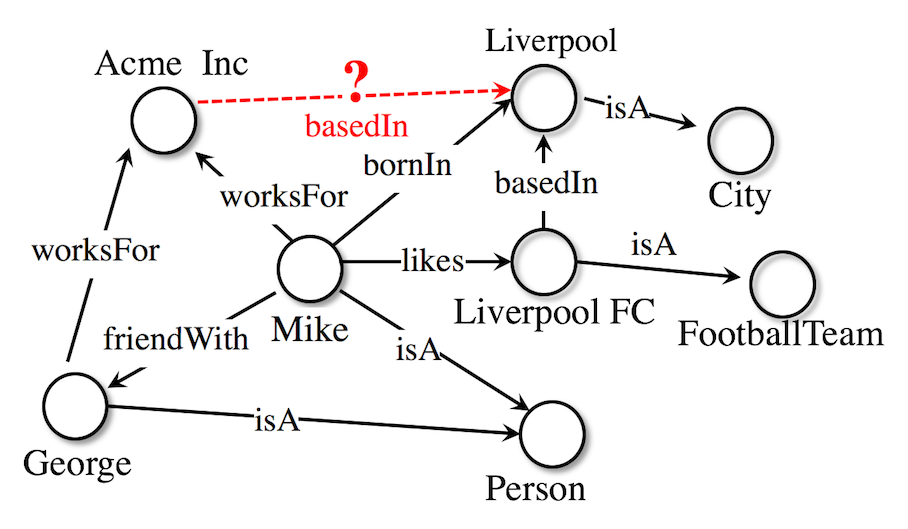

In [2]:
from IPython.display import Image

Image(filename='kg_lp.png')

In [3]:
import requests
from ampligraph.datasets import load_from_csv

url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football.csv'
open('football.csv', 'wb').write(requests.get(url).content)
X = load_from_csv('.', 'football.csv', sep=',')[:, 1:]

X[:5, ]

array([['TeamScotland', 'isHomeTeam', 'Match0'],
       ['TeamEngland', 'isAwayTeam', 'Match0'],
       ['TeamScotland', 'draws', 'Match0'],
       ['TeamEngland', 'draws', 'Match0'],
       ['Match0', 'inTournament', 'TournamentFriendly']], dtype=object)

## Vamos a crear un test set con 1000 enlaces (triplets)

In [4]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_test = train_test_split_no_unseen(X, test_size=5000)

In [5]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (443481, 3)
Test set size:  (5000, 3)


## Vamos a entrenar un modelo DistMult

In [6]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel

model = ScoringBasedEmbeddingModel(k=100,
                                   eta=10,
                                   scoring_type='DistMult',
                                   seed=0)


2024-09-08 18:12:49.452034: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:/usr/local/cuda-11.8/lib64
2024-09-08 18:12:49.481775: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-09-08 18:12:49.482235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebu

In [7]:
import ampligraph.latent_features.loss_functions as lfs
from tensorflow.keras.optimizers import Adam
from ampligraph.latent_features.regularizers import get as get_regularizer

optimizer = Adam(learning_rate=1e-4)
loss = lfs.PairwiseLoss({'margin': 0.005, 'reduction': 'sum'})
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

model.compile(loss=loss,
              optimizer=optimizer,
              entity_relation_regularizer=regularizer)

In [8]:
model.fit(X_train,
          batch_size=5000,
          epochs=200,
          verbose=False)

In [9]:
import numpy as np

filter = {'test': np.concatenate([X_train, X_test])}

ranks = model.evaluate(X_test,
                       use_filter=filter,
                       corrupt_side='s,o',
                       verbose=True)

501/501 [==============================] - 53s 105ms/step


In [10]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.16
MR: 7238.63
Hits@10: 0.28
Hits@3: 0.18
Hits@1: 0.10


## Clasificador de resultados de partidos

In [11]:
import pandas as pd

url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/football_graph.csv'
open('football_results.csv', 'wb').write(requests.get(url).content)

df = pd.read_csv("football_results.csv").sort_values("date")
df.isna().sum()
df = df.dropna()

df["train"] = df.date < "2014-01-01"
df.train.value_counts()

train
True     35714
False     5057
Name: count, dtype: int64

In [12]:
df["match_id"] = df.index.values.astype(str)
df["match_id"] =  "Match" + df.match_id
df["city_id"] = "City" + df.city.str.title().str.replace(" ", "")
df["country_id"] = "Country" + df.country.str.title().str.replace(" ", "")
df["home_team_id"] = "Team" + df.home_team.str.title().str.replace(" ", "")
df["away_team_id"] = "Team" + df.away_team.str.title().str.replace(" ", "")
df["tournament_id"] = "Tournament" + df.tournament.str.title().str.replace(" ", "")
df["neutral"] = df.neutral.astype(str)

## Creamos los triplets para el training set

In [13]:
triples = []
for _, row in df[df["train"]].iterrows():
    home_team = (row["home_team_id"], "isHomeTeamIn", row["match_id"])
    away_team = (row["away_team_id"], "isAwayTeamIn", row["match_id"])
    
    
    if row["home_score"] > row["away_score"]:
        score_home = (row["home_team_id"], "winnerOf", row["match_id"])
        score_away = (row["away_team_id"], "loserOf", row["match_id"])
    elif row["home_score"] < row["away_score"]:
        score_away = (row["away_team_id"], "winnerOf", row["match_id"])
        score_home = (row["home_team_id"], "loserOf", row["match_id"])
    else:
        score_home = (row["home_team_id"], "draws", row["match_id"])
        score_away = (row["away_team_id"], "draws", row["match_id"])
    home_score = (row["match_id"], "homeScores", np.clip(int(row["home_score"]), 0, 5))
    away_score = (row["match_id"], "awayScores", np.clip(int(row["away_score"]), 0, 5))
    
    
    tournament = (row["match_id"], "inTournament", row["tournament_id"])
    city = (row["match_id"], "inCity", row["city_id"])
    country = (row["match_id"], "inCountry", row["country_id"])
    neutral = (row["match_id"], "isNeutral", row["neutral"])
    year = (row["match_id"], "atYear", row["date"][:4])
    
    triples.extend((home_team, away_team, score_home, score_away, 
                    tournament, city, country, neutral, year, home_score, away_score))

## El grafo que hemos creado representa cada partido en base a varios triplets

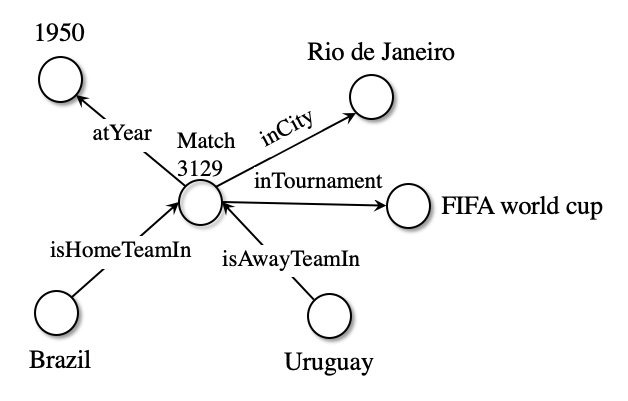

In [15]:
Image(filename='FootballGraph.png')

In [16]:
X_train, X_test = train_test_split_no_unseen(np.array(triples), test_size=10000)

In [17]:
model = ScoringBasedEmbeddingModel(k=100,
                                   eta=10,
                                   scoring_type='DistMult',
                                   seed=0)

model.compile(loss=loss,
              optimizer=optimizer,
              entity_relation_regularizer=regularizer)

model.fit(X_train,
          batch_size=5000,
          epochs=200,
          verbose=True)

Epoch 1/200
78/78 [==============================] - 4s 48ms/step - loss: 16.4259
Epoch 2/200
78/78 [==============================] - 3s 43ms/step - loss: 17.2746
Epoch 3/200
78/78 [==============================] - 3s 44ms/step - loss: 17.6917
Epoch 4/200
78/78 [==============================] - 3s 44ms/step - loss: 17.8196
Epoch 5/200
78/78 [==============================] - 3s 43ms/step - loss: 17.8493
Epoch 6/200
78/78 [==============================] - 3s 43ms/step - loss: 17.8440
Epoch 7/200
78/78 [==============================] - 3s 43ms/step - loss: 17.8242
Epoch 8/200
78/78 [==============================] - 3s 44ms/step - loss: 17.7977
Epoch 9/200
78/78 [==============================] - 3s 44ms/step - loss: 17.7676
Epoch 10/200
78/78 [==============================] - 3s 44ms/step - loss: 17.7352
Epoch 11/200
78/78 [==============================] - 3s 43ms/step - loss: 17.7016
Epoch 12/200
78/78 [==============================] - 3s 44ms/step - loss: 17.6671
Epoch 13/200


78/78 [==============================] - 3s 43ms/step - loss: 13.3918
Epoch 197/200
78/78 [==============================] - 3s 43ms/step - loss: 13.3781
Epoch 198/200
78/78 [==============================] - 3s 43ms/step - loss: 13.3644
Epoch 199/200
78/78 [==============================] - 3s 43ms/step - loss: 13.3508
Epoch 200/200
78/78 [==============================] - 3s 43ms/step - loss: 13.3372


In [18]:
df["results"] = (df.home_score > df.away_score).astype(int) + \
                (df.home_score == df.away_score).astype(int)*2 + \
                (df.home_score < df.away_score).astype(int)*3 - 1

In [19]:
df.results.value_counts(normalize=True)

results
0    0.486473
2    0.282456
1    0.231071
Name: proportion, dtype: float64

In [20]:
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,train,match_id,city_id,country_id,home_team_id,away_team_id,tournament_id,results
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,True,Match0,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly,1
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,True,Match1,CityLondon,CountryEngland,TeamEngland,TeamScotland,TournamentFriendly,0
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,True,Match2,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly,0
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,True,Match3,CityLondon,CountryEngland,TeamEngland,TeamScotland,TournamentFriendly,1
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,True,Match4,CityGlasgow,CountryScotland,TeamScotland,TeamEngland,TournamentFriendly,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40766,2019-07-10,Senegal,Benin,1.0,0.0,African Cup of Nations,Cairo,Egypt,True,False,Match40766,CityCairo,CountryEgypt,TeamSenegal,TeamBenin,TournamentAfricanCupOfNations,0
40767,2019-07-11,Ivory Coast,Algeria,1.0,1.0,African Cup of Nations,Suez,Egypt,True,False,Match40767,CitySuez,CountryEgypt,TeamIvoryCoast,TeamAlgeria,TournamentAfricanCupOfNations,1
40768,2019-07-11,Madagascar,Tunisia,0.0,3.0,African Cup of Nations,Cairo,Egypt,True,False,Match40768,CityCairo,CountryEgypt,TeamMadagascar,TeamTunisia,TournamentAfricanCupOfNations,2
40769,2019-07-14,Algeria,Nigeria,2.0,1.0,African Cup of Nations,Cairo,Egypt,True,False,Match40769,CityCairo,CountryEgypt,TeamAlgeria,TeamNigeria,TournamentAfricanCupOfNations,0


In [27]:
teams = pd.concat((df.home_team_id[df["train"]], df.away_team_id[df["train"]])).unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

In [30]:
def get_features_target(mask):
    
    def get_embeddings(team):
        return team_embeddings.get(team, np.full(100, np.nan))
    
    X = np.hstack((np.vstack(df[mask].home_team_id.apply(get_embeddings).values),
                   np.vstack(df[mask].away_team_id.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [31]:
clf_X_train, y_train = get_features_target((df["train"]))
clf_X_test, y_test = get_features_target((~df["train"]))

In [32]:
clf_X_train.shape, clf_X_test.shape

((35714, 200), (5057, 200))

In [33]:
from xgboost import XGBClassifier

In [34]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [35]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [36]:
y_pred = clf_model.predict(clf_X_test)

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(cm)


Accuracy: 0.5224
Confusion Matrix:
[[1814  239  329]
 [ 709  178  335]
 [ 576  227  650]]
